----

# <span style="color:darkred">Unsupervised NLP Analysis of Novelists</span>

__Author:__ Ryan Harper 

----

<a id="top"></a>

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>

<a id="ov"></a>

# <span style="color:darkblue">Overview</span>  <a href='#top'>(top)</a>

__Data Source:__
> NLTK Gutenberg

__Summary:__
> This project explores the variation in vocabulary and writing structure of three different authors by employing Word2Vec, IDF, and a gaussian mixture cluster model to examine the sentences in three different novels.

__Variables:__
>__author:__ _author of the novel_<br>
__sentence:__ _sentence from the novel/author_ <br>

<a id="exp"></a>

# <span style="color:darkblue">Experiment</span> <a href='#top'>(top)</a>

__Hypothesis:__ 
> Authors will use different vocabulary and collocations that will help models predict differences between the authors in an unsupervised environment.

__Observations:__
><li> Proper nouns (names and places) are the strongest indicator of different authors (via their specific novels)<br><br>  <li> Some frequently used 1 and 2 word expressions (i.e.'Oh' and 'was said') are a good indicator of different authors <br><br>
  <li> Clustering models on a Truncated SVD IDF vector does not appear to produce meaningful results. Future experiments might need to explore other ways to better vectorize sentences for cluster models.

__Method:__
> Imported and merged the three novels into a data set.<br><br>
> Split up the novels by sentences and random sampled the data.<br><br>
> Used IDF and SVD to assess important components and then matched them to the original sentences. <br><br>
> Used the Gaussian Mixture model (cluster model) to look at the three combined samples and to determine if clusters could be determined from sentences.<br><br>
> Used v_measurement and aikaike to assess the effectiveness of the clustering.

<a id="sec1"></a>

# <span style="color:darkblue">1. Cleaning the Data</span>  <a href='#top'>(top)</a>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from textblob import TextBlob
from IPython.display import display

In [2]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [3]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    text = str(text)
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub('\n'," ",text)
    text = re.sub('\r'," ",text)
    return text

def mlist(story):
    return [text_cleaner(i) for i in TextBlob(re.sub(r'Chapter \d+', '', story)).sentences]

def mtokens(story):
    return [list(i.words.lower()) for i in TextBlob(re.sub(r'Chapter \d+', '', story)).sentences]

In [4]:
# Load and clean the data.
chestertonbrown = mlist(gutenberg.raw('chesterton-brown.txt'))
edgeworth = mlist(gutenberg.raw('edgeworth-parents.txt'))
alice = mlist(gutenberg.raw('carroll-alice.txt'))

In [5]:
sentences = chestertonbrown + alice + edgeworth

In [6]:
def nl(name,data):
    return [name for i in range(len(data))]
name = nl('chesterton',chestertonbrown)+nl('edgeworth',edgeworth)+nl('carroll',alice)

In [7]:
stories = pd.DataFrame([sentences,name]).T.sample(frac=1,random_state=42)
stories.columns = ['sentence','author']

# IDF

In [8]:
vectorizer = TfidfVectorizer(max_df=0.3,
                             min_df=2,
                             stop_words='english', 
                             lowercase=True, #lower case
                             use_idf=True,#inverse document frequencies
                             norm=u'l2', #longer and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies
                            )

X_train, y_train = stories.sentence,stories.author

#Applying the vectorizer
stories_paras_tfidf=vectorizer.fit_transform(X_train)
print("Number of features: %d" % stories_paras_tfidf.get_shape()[1])

Number of features: 7289


In [9]:
#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = stories_paras_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

_Examine Features_

In [10]:
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0
print('Original sentence:', stories.iloc[0])
print('Tf_idf vector:', tfidf_bypara[10])

Original sentence: sentence    He never could see it.
author                   edgeworth
Name: 10289, dtype: object
Tf_idf vector: {'young': 0.2749451885947422, 'gentleman': 0.2969739539928582, 'pulled': 0.3475103973056092, 'lamb': 0.33069084107384444, 'ditch': 0.46741292397363693, 'fallen': 0.36739755241931726, 'pretty': 0.327432466825978, 'creature': 0.381344833398573}


In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [12]:
variances = []
for i in range (1,7001,500):
    svd= TruncatedSVD(i)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD on the training data, then project the training data.
    X_train_lsa = lsa.fit_transform(X_train_tfidf_csr)
    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    variances.append(total_variance)
    print('# of Features: {}'.format(i),end=' | ')

# of Features: 1 | # of Features: 501 | # of Features: 1001 | # of Features: 1501 | # of Features: 2001 | # of Features: 2501 | # of Features: 3001 | # of Features: 3501 | # of Features: 4001 | # of Features: 4501 | # of Features: 5001 | # of Features: 5501 | # of Features: 6001 | # of Features: 6501 | 

ValueError: x and y must be the same size

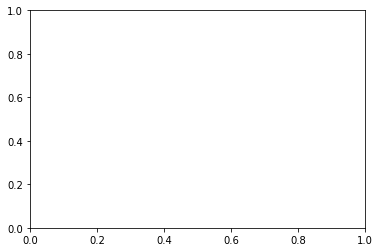

In [13]:
plt.scatter(range(10,8000,1000),variances)
plt.title('Truncated SVD: Explained Variance')

In [ ]:
svd= TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf_csr)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

In [ ]:
#Looking at what sorts of paragraphs our solution considers similar
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train.index)
paras_by_component['author'] = stories.author
paras_by_component['sentence'] = stories.sentence

In [ ]:
pd.options.display.width = 100
pd.options.display.max_colwidth = 100

In [ ]:
for i in range(5):
    component = i
    print('Component {}:'.format(component))
    df = pd.DataFrame(data = paras_by_component[[component,'author','sentence']]).sort_values(by=component,ascending=False)[0:40:5]
    df = df.reset_index();del df['index'];df.columns=['Similarity','Author','Sentence']
    display(df)
    print('')

In [ ]:
r = range(0,20)
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[r[0]:r[-1]+1,r[0]:r[-1]+1]
#Making a plot
plt.figure(figsize=(10,8))
ax = sns.heatmap(sim_matrix,yticklabels=r)
plt.show()

#Generating a key for the plot.
print('Key:')
for i in r:
    j = i-r[0]
    print("{}-{}: {}".format(i,stories.author.iloc[i],sim_matrix.index[j][0:100]))

In [ ]:
%%time
from sklearn.mixture import GaussianMixture

gm_range = range(2,8,1)
gm_aic = []
gm_predict = []
gm_score = []

gm_x = X_train_lsa
gm_y = y_train
for i in gm_range:
    # Declare and fit the model.
    gm = GaussianMixture(n_components=i,n_init=10,init_params='random')
    gm.fit(gm_x)
    # gm_predict.append(km.predict_fit(X_test_tfidf))
    gm_aic.append(gm.aic(gm_x))
    gm_predict.append(gm.predict(gm_x))
    gm_score.append(gm.score(gm_x,gm_y))
    
    
    #Predicted clusters.
    print('{} completed'.format(i),end=' | ')

In [ ]:
plt.scatter(range(2,8,1),gm_aic)
plt.savefig('aic.jpg')

# 5. Evaluate (w/ different criterion)

In [ ]:
from sklearn.metrics import v_measure_score

## _V-Measurement Criterion_

In [ ]:
table = pd.crosstab(y_train, gm_predict[1],margins = True)
table.index = list(y_train.unique()) + ['total'];table

# Word2Vec

In [ ]:
from gensim.models import word2vec
from gensim.utils import tokenize

In [ ]:
stories.tokens = stories.sentence.apply(tokenize).apply(list)

In [ ]:
%%time
load_model = False
 
vec_size = 200
word_vec = word2vec.Word2Vec(
    stories.tokens,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=5,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=vec_size,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

# List of words in model.
vocab = word_vec.wv.vocab.keys()